In [2]:
# NEET MCQ RAG System - Full Pipeline
# Directory structure:
# ├── main.py
# ├── pdfs/ (put NEET PDFs here)
# ├── extracted_images/
# └── faiss_index/

import os
import fitz  # PyMuPDF
import re
import numpy as np
import faiss
from PIL import Image
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import json
import torch


# Load model
text_model = SentenceTransformer("all-MiniLM-L6-v2")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# FAISS setup
DIM = 512 + 512  # text + image
index = faiss.IndexFlatL2(DIM)
metadata = []

# Ensure folders exist
os.makedirs("pdfs", exist_ok=True)
os.makedirs("extracted_images", exist_ok=True)
os.makedirs("faiss_index", exist_ok=True)




d:\NEETengine\nenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
d:\NEETengine\nenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lenovo\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by 

In [3]:
# Extract content from PDF
def extract_pdf_content(pdf_path):
    doc = fitz.open(pdf_path)
    all_data = []
    for page_num in range(len(doc)):
        page = doc[page_num]
        text = page.get_text()
        images = page.get_images(full=True)
        image_paths = []

        for i, img in enumerate(images):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            image_filename = f"extracted_images/page{page_num+1}_img{i}.{image_ext}"
            with open(image_filename, "wb") as f:
                f.write(image_bytes)
            image_paths.append(image_filename)

        all_data.append({
            "page": page_num + 1,
            "text": text,
            "images": image_paths,
        })
    return all_data


In [4]:
# Extract MCQs from raw text
def extract_mcqs(text):
    mcqs = re.split(r'\n\d+\.', text)
    results = []
    for mcq in mcqs:
        if len(mcq.strip()) < 20:
            continue
        match = re.search(r'\(a\)(.*?)\(b\)(.*?)\(c\)(.*?)\(d\)(.*)', mcq, re.DOTALL)
        if match:
            question = mcq.split("(a)")[0].strip()
            options = [match.group(i).strip() for i in range(1, 5)]
            results.append({"question": question, "options": options})
    return results



In [5]:
# Embed text using SentenceTransformer
def get_text_embedding(text):
    return text_model.encode(text)



In [6]:
# Embed image using CLIP
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    return outputs.detach().numpy().flatten()

In [7]:
# Index data into FAISS
def add_to_index(question, options, image_paths, meta):
    full_text = question + " " + " ".join(options)
    text_emb = get_text_embedding(full_text)
    image_emb = get_image_embedding(image_paths[0]) if image_paths else np.zeros(512)
    combined = np.concatenate([text_emb, image_emb])
    index.add(np.array([combined]).astype("float32"))
    metadata.append(meta)





In [8]:
# Save metadata to disk
def save_metadata():
    with open("faiss_index/metadata.json", "w") as f:
        json.dump(metadata, f, indent=2)
    faiss.write_index(index, "faiss_index/index.bin")

In [13]:
# Main pipeline to process PDF and index

for filename in os.listdir("pdfs"):
    if not filename.endswith(".pdf"):
        continue
    print(f"Processing {filename}...")
    pdf_data = extract_pdf_content(os.path.join("pdfs", filename))
    year = re.search(r"(20\d{2})", filename)
    year = year.group(1) if year else "Unknown"

    for page in pdf_data:
        mcqs = extract_mcqs(page["text"])
        for mcq in mcqs:
            meta = {
                "question": mcq["question"],
                "options": mcq["options"],
                "year": year,
                "chapter": "Unknown",  # You can add chapter detection later
                "image_path": page["images"][0] if page["images"] else None
            }
            # add_to_index(mcq["question"], mcq["options"], page["images"], meta)

# save_metadata()
print("Indexing complete.")


Processing neet1.pdf...
Indexing complete.


In [10]:
pdf_data

[{'page': 1,
  'text': 'Cell - The Unit of Life\nQuestion1\nMatch List-I with List-II:\n \n List-I\n \n List-II\n A.\n Fleming\n I.\n Disc shaped sacs or cisternae near cell nucleus\n B.\n Robert Brown\n II.\n Chromatin\n C.\n George Palade\n III.\n Ribosomes\n D.\n Camillo Golgi\n IV.\n Nucleus\nChoose the correct answer from the options given below:\n[NEET 2024 Re]\nOptions:\nA.\nA-II, B-IV, C-III, D-I\nB.\nA-II, B-III, C-I, D-IV\nC.\nA-I, B-II, C-III, D-IV\nD.\nA-IV, B-II, C-III, D-I\nAnswer: A\nSolution:\n• Nucleus as a cell organelle was first described by Robert Brown as early as 1831 .\n• Later the material of the nucleus stained by the basic dyes was given the name chromatin by Flemming.\n• Ribosomes are the granular structure first observed under the microscope as dense particle by George Palade.\n• Camillo Golgi first observed densely stained reticular structure near the nucleus. It consist of many disc shaped sac or\ncisternae.\nHence, A-II, B-IV, C-III, D-I is correct.\n \n

In [11]:
year

'Unknown'

In [14]:
meta

{'question': 'Options:\nA.',
 'options': ['B.',
  'C.',
  'D.',
  'Answer: A\nSolution:\n-------------------------------------------------------------------------------------------------\nQuestion71\n(i) Cristae of mitochondria(ii) Inner membrane of mitochondria(iii)\nCytoplasm(iv) Smooth endoplasmic reticulum(v) Rough endoplasmic\nreticulum(vi) Mitochondrial matrix(vii) Cell vacuole(viii) Nucleus The\ncorrect components are:\n2010\n(a) : A- Rough endoplasmic reticulum \nB- Smooth endoplasmic reticulum \nC- Nucleus \nD-Cytoplasm\nMiddle lamella is composed mainly of\n2009'],
 'year': 'Unknown',
 'chapter': 'Unknown',
 'image_path': 'extracted_images/page41_img0.jpeg'}

In [15]:
import re
import json

def extract_mcqs(text, year="Unknown", chapter="Unknown"):
    # Split questions
    questions = re.split(r'(?=Question\d+)', text.strip())
    extracted = []

    for q in questions:
        if not q.strip():
            continue

        # Extract question body
        question_match = re.search(r'Question\d+\s*(.*?)(?=Options:)', q, re.DOTALL)
        question_text = question_match.group(1).strip() if question_match else ""

        # Extract options
        options_match = re.findall(r'\b([A-D])\.\s*(.*)', q)
        options = [""] * 4
        for label, text_opt in options_match:
            idx = ord(label) - ord('A')
            options[idx] = text_opt.strip()

        # Extract answer
        answer_match = re.search(r'Answer:\s*([A-D])', q)
        answer = answer_match.group(1) if answer_match else ""

        # Extract solution
        solution_match = re.search(r'Solution:\s*(.*)', q, re.DOTALL)
        solution = solution_match.group(1).strip() if solution_match else ""

        # Build structured entry
        mcq = {
            "question": question_text,
            "options": options,
            "answer": answer,
            "solution": solution,
            "year": year,
            "chapter": chapter
        }

        extracted.append(mcq)

    return extracted





In [17]:
with open("neet_text_sample.txt", "r", encoding="utf-8") as f:
    text = f.read()

mcqs = extract_mcqs(text, year="2024", chapter="Cell Structure")

# Output as JSON
with open("extracted_mcqs.json", "w", encoding="utf-8") as f:
    json.dump(mcqs, f, indent=2, ensure_ascii=False)

print(f"✅ Extracted {len(mcqs)} MCQs to extracted_mcqs.json")


FileNotFoundError: [Errno 2] No such file or directory: 'neet_text_sample.txt'

In [4]:
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    return full_text


In [18]:
import re

def extract_mcqs_from_text(text):
    # Updated pattern for NEET style questions with year + numbered options
    pattern = re.compile(
        r'(\d+)\.\s+(.*?)(?:\((NEET\s?\d{4})\))?\s*\n1\.\s+(.*?)\n2\.\s+(.*?)\n3\.\s+(.*?)\n4\.\s+(.*?)\nAnswer\s*[:\-]?\s*([1-4])',
        re.DOTALL
    )

    matches = pattern.findall(text)

    mcqs = []
    for m in matches:
        question_text = m[1].strip()
        year = m[2].strip() if m[2] else "General"
        options = [m[3].strip(), m[4].strip(), m[5].strip(), m[6].strip()]
        answer_idx = int(m[7]) - 1
        answer_letter = ["A", "B", "C", "D"][answer_idx]

        mcqs.append({
            "question": question_text,
            "options": options,
            "answer": answer_letter,
            "solution": f"The correct answer is option ({answer_letter}): {options[answer_idx]}",
            "year": year,
            "chapter": "The Living World"
        })

    return mcqs


In [19]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert MCQs to vector strings
def mcq_to_text(mcq):
    return f"{mcq['question']} Options: {', '.join(mcq['options'])}"

def embed_mcqs(mcqs):
    texts = [mcq_to_text(mcq) for mcq in mcqs]
    vectors = model.encode(texts)
    return vectors


In [20]:
def store_in_faiss(vectors, mcqs):
    dim = vectors.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(np.array(vectors))
    faiss.write_index(index, "mcq_index.faiss")

    # Save MCQ metadata
    with open("mcq_map.json", "w") as f:
        json.dump(mcqs, f, indent=2)


In [21]:
def run_pipeline(pdf_path):
    text = extract_text_from_pdf(pdf_path)
    mcqs = extract_mcqs_from_text(text)
    vectors = embed_mcqs(mcqs)
    store_in_faiss(vectors, mcqs)


In [22]:
run_pipeline("./pdfs/Topic.pdf")


In [23]:
def search_mcqs(query, k=3):
    query_embedding = model.encode([query])
    D, I = index.search(np.array(query_embedding), k)
    results = []
    for i in I[0]:
        mcq = mcqs[i]
        results.append({
            "year": mcq.get("year", "Unknown"),
            "question": mcq["question"],
            "options": mcq["options"],
            "answer": mcq["answer"],
            "solution": mcq["solution"]
        })
    return results


In [24]:
import faiss
import json
import numpy as np
from sentence_transformers import SentenceTransformer

# Load the index and map
index = faiss.read_index("mcq_index.faiss")

with open("mcq_map.json", "r") as f:
    mcqs = json.load(f)

# Load the same embedding model used earlier
model = SentenceTransformer("all-MiniLM-L6-v2")


In [25]:
query = "What is the defining feature of life?"
top_mcqs = search_mcqs(query, k=3)

for i, mcq in enumerate(top_mcqs, 1):
    print(f"\n🧠 MCQ #{i} ({mcq['year']})")
    print("Q:", mcq["question"])
    for idx, opt in zip("abcd", mcq["options"]):
        print(f"({idx}) {opt}")
    print("Answer:", mcq["answer"])
    print("Explanation:", mcq["solution"])




🧠 MCQ #1 (NEET 2013)
Q: This is an incorrect statement
(a) Botanical gardens have a collection of living plants for reference
(b) Herbarium houses dried, pressed and preserved plant specimens
(c) Key is a taxonomic aid for identification of specimens
(d) A museum has collection of photographs of animals and plants
Answer: D
Explanation: The correct answer is option (D): A museum has collection of photographs of animals and plants

🧠 MCQ #2 (General)
Q: Study the four statements (I-IV) given below and select the two correct ones out of them : 
(NEET 2016, Phase II) 
I. Definition of biological species was given by Ernst Mayr. 
II. Photoperiod does not affect reproduction in plants. 
III. Binomial nomenclature system was given by RH Whittaker. 
IV. In unicellular organisms, reproduction is synonymous with growth. 
The two correct statements are
(a) II and III
(b) III and IV
(c) I and IV
(d) I and II
Answer: C
Explanation: The correct answer is option (C): I and IV

🧠 MCQ #3 (General)
Q:

In [26]:
def search_mcqs(query, k=5, year=None, chapter=None):
    query_embedding = model.encode([query])
    D, I = index.search(np.array(query_embedding), k * 2)  # Over-fetch to filter later

    results = []
    for i in I[0]:
        mcq = mcqs[i]
        
        if year and mcq.get("year", "").lower() != year.lower():
            continue
        if chapter and mcq.get("chapter", "").lower() != chapter.lower():
            continue

        results.append({
            "year": mcq.get("year", "Unknown"),
            "chapter": mcq.get("chapter", "Unknown"),
            "question": mcq["question"],
            "options": mcq["options"],
            "answer": mcq["answer"],
            "solution": mcq["solution"]
        })

        if len(results) >= k:
            break

    return results


In [28]:
# Example 1: Filter by year
results1 = search_mcqs("classification system", year="NEET 2016", k=3)

# Example 2: Filter by chapter
results2 = search_mcqs("scientific name of mango", chapter="The Living World", k=3)

# Example 3: Filter by both
results3 = search_mcqs("", year="NEET 2023", chapter="The Living World", k=3)


In [29]:
for i, mcq in enumerate(results3, 1):
    print(f"\n🧠 MCQ #{i} ({mcq['year']} | {mcq['chapter']})")
    print("Q:", mcq["question"])
    for idx, opt in zip("abcd", mcq["options"]):
        print(f"({idx}) {opt}")
    print("Answer:", mcq["answer"])
    print("Explanation:", mcq["solution"])



🧠 MCQ #1 (NEET 2023 | The Living World)
Q: House fly belongs to _______ family.
(a) Cyprinidae
(b) Hominidae
(c) Calliphoridae
(d) Muscidae
Answer: D
Explanation: The correct answer is option (D): Muscidae


In [31]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install pytesseract

  Using cached pytesseract-0.3.13-py3-none-any.whl.metadata (11 kB)
Using cached pytesseract-0.3.13-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [69]:
def extract_text_and_images_with_location(pdf_path, image_dir="mcq_images"):
    import fitz
    import os
    from PIL import Image
    import pytesseract

    doc = fitz.open(pdf_path)
    os.makedirs(image_dir, exist_ok=True)

    all_data = []

    for page_num in range(len(doc)):
        page = doc[page_num]
        blocks = page.get_text("dict")["blocks"]
        text_blocks = [b for b in blocks if "lines" in b]

        images = []
        for i, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = fitz.Pixmap(doc, xref)
            img_path = f"{image_dir}/page{page_num}_img{i}.png"

            # Save image
            if base_image.n < 5:
                base_image.save(img_path)
            else:
                pix = fitz.Pixmap(fitz.csRGB, base_image)
                pix.save(img_path)
                pix = None

            # Run OCR on image
            try:
                ocr_text = pytesseract.image_to_string(Image.open(img_path))
            except Exception as e:
                ocr_text = ""

            print("ocr_text", ocr_text)

            # Get image location (bbox)
            img_rect = fitz.Rect(img[1])  # x0, y0, x1, y1
            images.append({
                "path": img_path,
                "ocr_text": ocr_text.strip(),
                "rect": list(img_rect),
            })

        all_data.append({
            "page": page_num,
            "text_blocks": text_blocks,
            "images": images,
        })
        print(images)

    return all_data


In [70]:
pages = extract_text_and_images_with_location("./pdfs/neet1.pdf")

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
ocr_text 


ValueError: not enough values to unpack (expected 4, got 1)

In [76]:
import fitz  # PyMuPDF
import os
from PIL import Image

def extract_text_and_images(pdf_path, image_dir="mcq_images"):
    doc = fitz.open(pdf_path)
    os.makedirs(image_dir, exist_ok=True)

    mcqs = []
    img_count = 0

    for page_num, page in enumerate(doc):
        blocks = page.get_text("blocks")
        print("blocks", blocks)
        
        text = "\n".join(block[4] for block in blocks).strip()
        print("text", text)

        images = []
        for img in page.get_images(full=True):
            xref = img[0]
            pix = fitz.Pixmap(doc, xref)
            img_path = os.path.join(image_dir, f"page{page_num}_img{img_count}.png")
            print("img_path", img_path)
            if pix.n < 5:
                pix.save(img_path)
            else:
                pix1 = fitz.Pixmap(fitz.csRGB, pix)
                pix1.save(img_path)
                pix1 = None
            images.append(img_path)
            img_count += 1

        mcqs.append({
            "page": page_num,
            "text": text,
            "images": images
        })
        print("mcqs", mcqs)
        print("image_count", img_count)
        print("images", images)

    return mcqs


In [77]:
pages = extract_text_and_images("./pdfs/neet1.pdf")

blocks [(185.06788635253906, 61.58898162841797, 408.9879150390625, 83.25384521484375, 'Cell - The Unit of Life\n', 0, 0), (14.360311508178711, 101.92920684814453, 120.01396179199219, 123.59407043457031, 'Question1\n', 1, 0), (14.360311508178711, 137.9540252685547, 205.7403106689453, 154.20266723632812, 'Match List-I with List-II:\n', 2, 0), (27.96613121032715, 171.67367553710938, 409.1022644042969, 182.506103515625, ' \n List-I\n \n List-II\n', 3, 0), (17.241756439208984, 187.33251953125, 430.5337829589844, 198.06590270996094, ' A.\n Fleming\n I.\n Disc shaped sacs or cisternae near cell nucleus\n', 4, 0), (17.241756439208984, 202.89231872558594, 258.95404052734375, 213.62570190429688, ' B.\n Robert Brown\n II.\n Chromatin\n', 5, 0), (17.241756439208984, 218.45211791992188, 259.7361145019531, 229.1855010986328, ' C.\n George Palade\n III.\n Ribosomes\n', 6, 0), (17.241756439208984, 234.0119171142578, 247.427001953125, 244.74530029296875, ' D.\n Camillo Golgi\n IV.\n Nucleus\n', 7, 0), 

In [ ]:
# from collections import defaultdict

# def build_page_to_images_map(pages):
#     page_image_map = defaultdict(list)
#     for entry in pages:
#         # for img in entry['images']:
#             page_image_map[entry['page']].append(img)
#     return page_image_map


In [ ]:
# def parse_mcqs(pages):
#     structured = []
#     page_image_map = build_page_to_images_map(pages)

#     for entry in pages:
#         text = entry["text"]
#         page = entry["page"]
#         images_for_page = page_image_map[page]

#         # apply your MCQ regex matching logic here...
#         matches = re.findall(
#             r'Question\d+\s+(.*?)\s*\[NEET\s*(\d{4})[^\]]*\].*?Options:\s+A\.\s+(.*?)\s+B\.\s+(.*?)\s+C\.\s+(.*?)\s+D\.\s+(.*?)\s+Answer\s*[:\-]?\s*([A-D])\s+Solution:\s+(.*?)\n',
#             text, re.DOTALL
#         )

#         for m in matches:
#             structured.append({
#                 "question": m[0].strip(),
#                 "year": f"NEET {m[1]}",
#                 "options": [m[2].strip(), m[3].strip(), m[4].strip(), m[5].strip()],
#                 "answer": m[6].strip().upper(),
#                 "solution": m[7].strip(),
#                 "chapter": "Cell - The Unit of Life",
#                 "images": images_for_page
#             })

#     return structured


In [82]:
def parse_mcqs_from_text_blocks(pages):
    mcqs = []

    for entry in pages:
        text = entry["text"]
        images = entry["images"]
        page = entry["page"]

        # Split by "Question" keyword (used in NEET PDFs)
        blocks = [b.strip() for b in text.split("Question") if b.strip()]

        for block in blocks:
            try:
                qnum = block.split('\n')[0]
                content = block[len(qnum):].strip()

                # Basic extraction
                q_match = re.search(r"(.*?)\nOptions:", content, re.DOTALL)
                options_match = re.findall(r"([A-Da-d])[\.\)]\s+(.*?)\n", content)
                answer_match = re.search(r"Answer\s*[:\-]?\s*([A-Da-d1-4])", content)
                solution_match = re.search(r"Solution\s*[:\-]?\s*(.*)", content, re.DOTALL)

                if q_match and options_match and answer_match:
                    question = q_match.group(1).strip()
                    options = [opt[1].strip() for opt in options_match[:4]]
                    ans_raw = answer_match.group(1).strip().upper()
                    answer = {"1": "A", "2": "B", "3": "C", "4": "D"}.get(ans_raw, ans_raw)
                    solution = solution_match.group(1).strip() if solution_match else ""

                    mcqs.append({
                        "question": question,
                        "options": options,
                        "answer": answer,
                        "solution": solution,
                        "year": "NEET 2024",
                        "chapter": "Cell - The Unit of Life",
                        "images": images,
                        "page": page
                    })
            except Exception as e:
                print(f"⚠️ Error parsing block: {e}")
                continue

    return mcqs


In [78]:
import re

def parse_mcqs(pages):
    structured = []
    for entry in pages:
        text = entry["text"]
        images = entry["images"]
        print("images",images)
        matches = re.findall(
            r'Question\d+\s+(.*?)\s*\[NEET\s*(\d{4})[^\]]*\].*?Options:\s+A\.\s+(.*?)\s+B\.\s+(.*?)\s+C\.\s+(.*?)\s+D\.\s+(.*?)\s+Answer\s*[:\-]?\s*([A-D])\s+Solution:\s+(.*?)\n', 
            text, re.DOTALL)

        for m in matches:
            structured.append({
                "question": m[0].strip(),
                "year": f"NEET {m[1]}",
                "options": [m[2].strip(), m[3].strip(), m[4].strip(), m[5].strip()],
                "answer": m[6].strip().upper(),
                "solution": m[7].strip(),
                "chapter": "Cell - The Unit of Life",
                "images": images
            })
    return structured


In [83]:
mcqs = parse_mcqs_from_text_blocks(pages)

In [84]:
mcqs

[{'question': 'Match List-I with List-II:\n\n \n List-I\n \n List-II\n\n A.\n Fleming\n I.\n Disc shaped sacs or cisternae near cell nucleus\n\n B.\n Robert Brown\n II.\n Chromatin\n\n C.\n George Palade\n III.\n Ribosomes\n\n D.\n Camillo Golgi\n IV.\n Nucleus\n\nChoose the correct answer from the options given below:\n\n[NEET 2024 Re]',
  'options': ['Fleming', 'Robert Brown', 'George Palade', 'Camillo Golgi'],
  'answer': 'A',
  'solution': '• Nucleus as a cell organelle was first described by Robert Brown as early as 1831 .\n\n• Later the material of the nucleus stained by the basic dyes was given the name chromatin by Flemming.\n\n• Ribosomes are the granular structure first observed under the microscope as dense particle by George Palade.\n\n• Camillo Golgi first observed densely stained reticular structure near the nucleus. It consist of many disc shaped sac or\ncisternae.\n\nHence, A-II, B-IV, C-III, D-I is correct.\n\n \n\n------------------------------------------------------

In [ ]:
    "./mcq_image/spage12_img0.png"

In [80]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json

model = SentenceTransformer('all-MiniLM-L6-v2')

def embed_and_store(mcqs):
    texts = [f"{m['question']} Options: {', '.join(m['options'])}" for m in mcqs]
    vectors = model.encode(texts)

    index = faiss.IndexFlatL2(len(vectors[0]))
    index.add(np.array(vectors))

    faiss.write_index(index, "neet_index.faiss")
    with open("neet_map.json", "w") as f:
        json.dump(mcqs, f, indent=2)


In [81]:
embed_and_store(mcqs)

In [56]:
def retrieve_mcqs(query, k=3, year=None, chapter=None):
    index = faiss.read_index("neet_index.faiss")
    with open("neet_map.json") as f:
        mcqs = json.load(f)

    q_vec = model.encode([query])
    D, I = index.search(np.array(q_vec), k * 2)

    results = []
    for i in I[0]:
        mcq = mcqs[i]
        if year and year.lower() not in mcq["year"].lower():
            continue
        if chapter and chapter.lower() not in mcq["chapter"].lower():
            continue
        results.append(mcq)
        if len(results) >= k:
            break
    return results


In [57]:
from PIL import Image
from IPython.display import display

def show_mcq(mcq):
    print(f"\n📘 {mcq['chapter']} | 📅 {mcq['year']}")
    print("Q:", mcq['question'])
    for i, opt in zip("ABCD", mcq['options']):
        print(f"({i}) {opt}")
    print("Answer:", mcq['answer'])
    print("Explanation:", mcq['solution'])

    for img_path in mcq['images']:
        print(f"🖼️ Image: {img_path}")
        img = Image.open(img_path)
        display(img)


In [60]:
pages = extract_text_and_images("./pdfs/neet1.pdf")
mcqs = parse_mcqs(pages)
embed_and_store(mcqs)

results = retrieve_mcqs("Match List-I with List-II:\n\n \n List-I\n \n List-II\n\n A.\n Fleming\n I.\n Disc shaped sacs or cisternae near cell nucleus\n\n B.\n Robert Brown\n II.\n Chromatin\n\n C.\n George Palade\n III.\n Ribosomes\n\n D.\n Camillo Golgi\n IV.\n Nucleus\n\nChoose the correct answer from the options given below:")
for r in results:
    show_mcq(r)



📘 Cell - The Unit of Life | 📅 NEET 2024
Q: Match List-I with List-II:

 
 List-I
 
 List-II

 A.
 Fleming
 I.
 Disc shaped sacs or cisternae near cell nucleus

 B.
 Robert Brown
 II.
 Chromatin

 C.
 George Palade
 III.
 Ribosomes

 D.
 Camillo Golgi
 IV.
 Nucleus

Choose the correct answer from the options given below:
(A) A-II, B-IV, C-III, D-I
(B) A-II, B-III, C-I, D-IV
(C) A-I, B-II, C-III, D-IV
(D) A-IV, B-II, C-III, D-I
Answer: A
Explanation: • Nucleus as a cell organelle was first described by Robert Brown as early as 1831 .

📘 Cell - The Unit of Life | 📅 NEET 2024
Q: Match List-I with List-II.

 
 List-I
 
 List-II

 A.
  F1 Particles
 I
 Chromosomes

 B.
 Histones
 II
 Cilia

 C.
 Axoneme
 III
 Golgi apparatus

 D.
 Cisternae
 IV
 Mitochondria

Choose the correct answer from the options given below:
(A) A-II, B-I, C-IV, D-III
(B) A-IV, B-I, C-II, D-III
(C) A-IV, B-I, C-III, D-II
(D) A-IV, B-III, C-I, D-II
Answer: B
Explanation: F1 particles or oxysomes are found on the inner 

In [61]:
results

[{'question': 'Match List-I with List-II:\n\n \n List-I\n \n List-II\n\n A.\n Fleming\n I.\n Disc shaped sacs or cisternae near cell nucleus\n\n B.\n Robert Brown\n II.\n Chromatin\n\n C.\n George Palade\n III.\n Ribosomes\n\n D.\n Camillo Golgi\n IV.\n Nucleus\n\nChoose the correct answer from the options given below:',
  'year': 'NEET 2024',
  'options': ['A-II, B-IV, C-III, D-I',
   'A-II, B-III, C-I, D-IV',
   'A-I, B-II, C-III, D-IV',
   'A-IV, B-II, C-III, D-I'],
  'answer': 'A',
  'solution': '• Nucleus as a cell organelle was first described by Robert Brown as early as 1831 .',
  'chapter': 'Cell - The Unit of Life',
  'images': []},
 {'question': 'Match List-I with List-II.\n\n \n List-I\n \n List-II\n\n A.\n  F1 Particles\n I\n Chromosomes\n\n B.\n Histones\n II\n Cilia\n\n C.\n Axoneme\n III\n Golgi apparatus\n\n D.\n Cisternae\n IV\n Mitochondria\n\nChoose the correct answer from the options given below:',
  'year': 'NEET 2024',
  'options': ['A-II, B-I, C-IV, D-III',
   'A

In [62]:
results

[{'question': 'Match List-I with List-II:\n\n \n List-I\n \n List-II\n\n A.\n Fleming\n I.\n Disc shaped sacs or cisternae near cell nucleus\n\n B.\n Robert Brown\n II.\n Chromatin\n\n C.\n George Palade\n III.\n Ribosomes\n\n D.\n Camillo Golgi\n IV.\n Nucleus\n\nChoose the correct answer from the options given below:',
  'year': 'NEET 2024',
  'options': ['A-II, B-IV, C-III, D-I',
   'A-II, B-III, C-I, D-IV',
   'A-I, B-II, C-III, D-IV',
   'A-IV, B-II, C-III, D-I'],
  'answer': 'A',
  'solution': '• Nucleus as a cell organelle was first described by Robert Brown as early as 1831 .',
  'chapter': 'Cell - The Unit of Life',
  'images': []},
 {'question': 'Match List-I with List-II.\n\n \n List-I\n \n List-II\n\n A.\n  F1 Particles\n I\n Chromosomes\n\n B.\n Histones\n II\n Cilia\n\n C.\n Axoneme\n III\n Golgi apparatus\n\n D.\n Cisternae\n IV\n Mitochondria\n\nChoose the correct answer from the options given below:',
  'year': 'NEET 2024',
  'options': ['A-II, B-I, C-IV, D-III',
   'A

In [85]:
# Single MCQ with image path
mcqs = [
    {
        "question": "Match List-I with List-II:\n\nList-I\nA. Fleming\nB. Robert Brown\nC. George Palade\nD. Camillo Golgi\n\nList-II\nI. Disc shaped sacs\nII. Chromatin\nIII. Ribosomes\nIV. Nucleus\n\nChoose the correct answer:",
        "year": "NEET 2024",
        "options": [
            "A-II, B-IV, C-III, D-I",
            "A-II, B-III, C-I, D-IV",
            "A-I, B-II, C-III, D-IV",
            "A-IV, B-II, C-III, D-I"
        ],
        "answer": "A",
        "solution": "• Nucleus was first described by Robert Brown in 1831.",
        "chapter": "Cell - The Unit of Life",
        "images": ["./mcq_images/page12_img0.png"]
    }
]


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json

# Load embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create vector from question + options
def mcq_to_vector(mcq):
    full_text = f"{mcq['question']}\nOptions: {', '.join(mcq['options'])}"
    return model.encode([full_text])[0]

# Embed and store
vectors = np.array([mcq_to_vector(mcq) for mcq in mcqs])
index = faiss.IndexFlatL2(vectors.shape[1])
index.add(vectors)

# Save metadata
with open("mcq_metadata.json", "w") as f:
    json.dump(mcqs, f, indent=2)

faiss.write_index(index, "mcq_index.faiss")


In [87]:
# Load everything back
index = faiss.read_index("mcq_index.faiss")
with open("mcq_metadata.json", "r") as f:
    mcqs = json.load(f)

query = "Who discovered the nucleus in a cell?"
query_vec = model.encode([query])
D, I = index.search(np.array(query_vec), k=1)

# Show result
for idx in I[0]:
    mcq = mcqs[idx]
    print(f"📘 {mcq['chapter']} | 📅 {mcq['year']}")
    print("Q:", mcq["question"])
    for i, opt in zip("ABCD", mcq["options"]):
        print(f"({i}) {opt}")
    print("✅ Answer:", mcq["answer"])
    print("🧠 Explanation:", mcq["solution"])
    print("🖼️ Image path:", mcq["images"])


📘 Cell - The Unit of Life | 📅 NEET 2024
Q: Match List-I with List-II:

List-I
A. Fleming
B. Robert Brown
C. George Palade
D. Camillo Golgi

List-II
I. Disc shaped sacs
II. Chromatin
III. Ribosomes
IV. Nucleus

Choose the correct answer:
(A) A-II, B-IV, C-III, D-I
(B) A-II, B-III, C-I, D-IV
(C) A-I, B-II, C-III, D-IV
(D) A-IV, B-II, C-III, D-I
✅ Answer: A
🧠 Explanation: • Nucleus was first described by Robert Brown in 1831.
🖼️ Image path: ['./mcq_images/page12_img0.png']


📘 Cell - The Unit of Life | 📅 NEET 2024
Q: Match List-I with List-II:

List-I
A. Fleming
B. Robert Brown
C. George Palade
D. Camillo Golgi

List-II
I. Disc shaped sacs
II. Chromatin
III. Ribosomes
IV. Nucleus

Choose the correct answer:
(A) A-II, B-IV, C-III, D-I
(B) A-II, B-III, C-I, D-IV
(C) A-I, B-II, C-III, D-IV
(D) A-IV, B-II, C-III, D-I
✅ Answer: A
🧠 Explanation: • Nucleus was first described by Robert Brown in 1831.


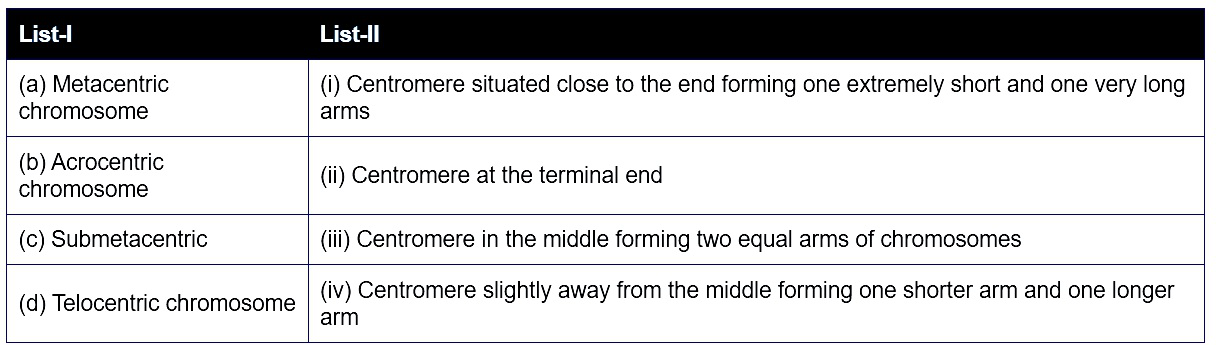

In [88]:
from PIL import Image
from IPython.display import display

# Continue from previous retrieval logic
for idx in I[0]:
    mcq = mcqs[idx]
    print(f"📘 {mcq['chapter']} | 📅 {mcq['year']}")
    print("Q:", mcq["question"])
    for i, opt in zip("ABCD", mcq["options"]):
        print(f"({i}) {opt}")
    print("✅ Answer:", mcq["answer"])
    print("🧠 Explanation:", mcq["solution"])

    # Show image(s)
    for image_path in mcq["images"]:
        try:
            img = Image.open(image_path)
            display(img)
        except Exception as e:
            print(f"⚠️ Failed to load image {image_path}: {e}")
